# Self-normalized importance sampling
Alex Gorodetsky, 
Initial: September, 2020
Updated: January, 2024

In [1]:
%matplotlib widget
from typing import Callable
from dataclasses import dataclass

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from montecarlo import MonteCarloEstimate

## A first look at data 

Lets take a look at a simple problem of linear regression and try to apply importance sampling to obtain samples from the posterior. We will pretend we don't know that the posterior of a Linear-Gaussian problem is Gaussian (you don't actually know this yet anyway!) Instead we will use importance sampling to sample from it.

Lets say we want to fit a simple linear model
\begin{equation}
g(x; \theta) = \theta x,
\end{equation}
where $\theta$ is some unknown parameter. Lets assume that we have some independent (noisy) data $\mathcal{D} = [(x^{(1)},y^{(1)}), \ldots, (x^{(n)}, y^{(n)})].$  

Note that we can write a probabilistic model for the data by noticing that 
\begin{equation}
y^{(i)} = g(x^{(i)}; \theta) + \xi^{(i)} = x^{(i)}\theta + \xi^{(i)}
\end{equation}
where $\xi$ is a Gaussian with zero mean and variance $\sigma^2$. 

**Questions**
1. What is the conditional density of a data point $f_{Y}(y\mid \theta, x)$?
2. If $\theta \sim \mathcal{N}(\mu, \eta^2)$ what is the marginal density $f_Y(y \mid x)$? 

**Answers**

The conditional density is 
\begin{equation}
f_{Y|\Theta}(y \mid \theta, x) = \frac{1}{\sqrt{2 \pi}\sigma} \exp\left( -\frac{1}{2\sigma^2} \left(y - x\theta\right)^2\right)
\end{equation}
Note that this is a Gaussian with mean $x\theta$ and variance $\sigma^2$; the fact that this is a Gaussian is because the equation for $y$ can be viewed as adding a constant to a Gaussian random variable. Those rules about scaling / shifting Gaussians are very important and will continue to show up

For similar reasons, the marginal distribution is
\begin{equation}
f_Y(y \mid x) \sim \mathcal{N}(\mu x, x^2\eta^2 + \sigma^2)
\end{equation}
where $Y$ is viewed as scaling a Gaussian and then adding a new independent Gaussian.

In [3]:
@dataclass
class Dataset:
    x: np.ndarray
    y: np.ndarray

@dataclass
class LinearModel:
    slope: float
    offset: float

true_noise = 0.05
num_data = 5
true_model = LinearModel(0.2, 0.0)

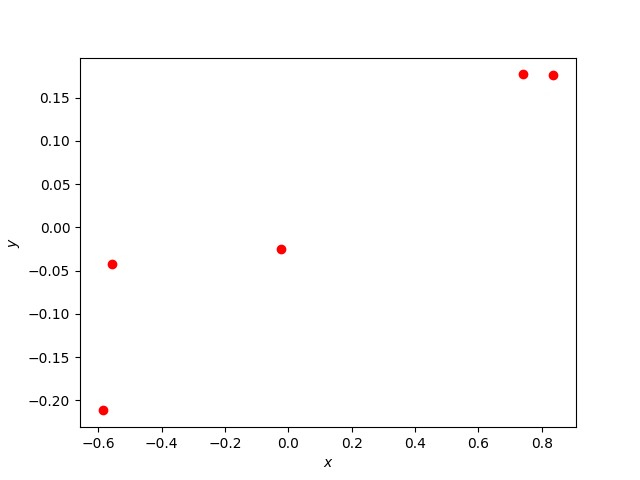

In [4]:
def get_data(ndata: int, noise_std: float) -> Dataset:
    """Our observer of the world, we request a number of data points and it returns noisy measurements of the data"""
    np.random.seed(5)  # for reproducibility
    x = np.random.rand(ndata)*2.0 - 1.0  # [uniform on [-1,1]]
    true_y = true_model.slope * x + true_model.offset
    noise = np.random.randn(ndata) * noise_std
    measured_y = true_y + noise
    return Dataset(x, measured_y)

dataset = get_data(num_data, true_noise)
plt.figure()
plt.plot(dataset.x, dataset.y, 'ro')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

We are primarily interested in predicting the function $g(x; \theta)$ at arbitrary values of $x.$ However, since we don't know $\theta$, we need to learn it first. We treat it as a random variable $\Theta$ and learning is defined as computing a probability distribution $P_{\Theta}(\theta \in d\theta \mid \mathcal{D})$; the probability distribution over the parameters given the data. 

This distribution is obtained with Bayes rule. We write Bayes rule in probability density form as
\begin{equation}
f_{\Theta \mid \mathcal{D}}(\theta \mid \mathcal{D}) = \frac{1}{f_{\mathcal{D}}(\mathcal{D})} f_{\mathcal{D} \mid \Theta} (\mathcal{D} \mid \theta) f_{\Theta}(\theta) 
\end{equation}

1. $f_{\Theta}$: the prior distribution, we will use a standard normal
2. $f_{\mathcal{D} \mid \Theta}$: the likelihood, we will assume the data points are independent and corrupted by Gaussian noise with a small standard deviation
\begin{equation}
 f_{\mathcal{D} \mid \Theta}(\mathcal{D} \mid \theta) = \prod_{i=1}^n f_{Y\mid \Theta}(y^{(i)} \mid \theta, x^{(i)}) = \prod_{i=1}^n \mathcal{N}(y^{(i)}; x^{(i)}\theta, \sigma^2) = \prod_{i=1}^n\left(\frac{1}{\sqrt{2\pi} \sigma} \exp\left(-\frac{1}{2\sigma^2}\left(y^{(i)} - x^{(i)} \theta\right)^2 \right)\right)
 \end{equation}
3. $f_{\Theta}(\theta \mid \mathcal{D})$: the posterior, it summarizes the information about the parameter that we learned from the data
4. $f_{\mathcal{D}}$: the evidence, in general we cannot compute this (it is as hard as the underlying problem, if not harder)

\begin{equation}
f_{\mathcal{D}}(\mathcal{D}) = \int f_{\mathcal{D} \mid \Theta} (\mathcal{D} \mid \theta) f_{\Theta}(\theta) d\theta
\end{equation}

Because we cannot compute the normalizing factor (in this particular example, we actually could -- see if you can work it out), we can only evaluate the posterior up to a normalizing factor 
\begin{equation}
f_{\Theta \mid \mathcal{D}}(\theta \mid \mathcal{D}) \propto f_{\mathcal{D} \mid \Theta} (\mathcal{D} \mid \theta) f_{\Theta}(\theta) 
\end{equation}

Finally, our goal is to predict $g(x)$, since $\theta$ is uncertain we will look at the expectation and variance of the predictions
\begin{equation}
\mathbb{E}\left[g(x, \Theta)\right] = \int g(x; \theta) f_{\Theta}(\theta \mid \mathcal{D}) d\theta = \int x \theta f_{\Theta}(\theta \mid \mathcal{D}) d\theta = x \mathbb{E}_{f_{\Theta}(\theta \mid \mathcal{D})} \left[\Theta\right]
\end{equation}
For the variance a straightforward calculation will yield
\begin{equation}
\mathbb{V}\text{ar}\left[g(x, \Theta)\right] = x^2\mathbb{V}\text{ar}_{f_{\Theta}(\theta \mid \mathcal{D})} \left[\Theta\right]
\end{equation}

We now use self-normalized importance sampling to solve this problem. 

*Note we do this because we pretend like we cannot compute $Z$ in closed form here. By the way, because this problem is linear and uses Gaussian distributions, it actually does have an analytic solution. The posterior is Gaussian and we will cover this in great depth later on. However, for nonlinear problems this example holds.*

In [5]:
class LinearGaussian:
    """A probabilistic model for Bayesian inference """
    noise_std: float

    def __init__(self, noise_std: float = 0.1):
        self.noise_std = noise_std

    def prior(self, param: np.ndarray) -> np.ndarray:
        """Standard Normal Gaussian prior"""
        pdf = stats.norm.pdf(param)
        return pdf

    def sample_prior(self, num_samples: int) -> np.ndarray:
        return np.random.randn(num_samples)

    def likelihood(self, x: np.ndarray, y: np.ndarray, param: np.ndarray) -> np.ndarray:
        """Gaussian likelihood assuming independent observations."""
        like = np.prod([stats.norm.pdf((yy-param*xx), scale=self.noise_std) for yy, xx in zip(y, x)])
        return like

    def unnormalized_posterior(self, x: np.ndarray, y: np.ndarray, param: np.ndarray) -> np.ndarray:
        """The unnormalized posterior, simply a product of the prior and the likelihood"""
        return self.prior(param) * self.likelihood(x, y, param)

In [6]:
model = LinearGaussian(noise_std=true_noise)

### The prior

The prior distribution represents our belief prior to seeing data

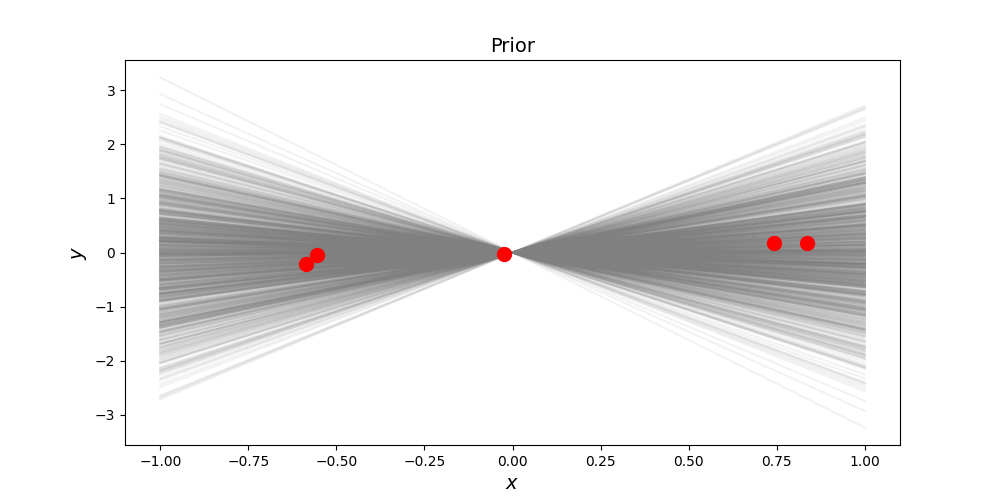

In [7]:
def plot_prior() -> None:
    xplot = np.linspace(-1, 1, 100)
    plt.figure(figsize=(10, 5))
    for ii in range(1000):
        plt.plot(xplot, model.sample_prior(1) * xplot, color='grey', alpha=0.1)
    plt.plot(dataset.x, dataset.y, 'ro', ms=10)
    plt.title("Prior", fontsize=14)
    plt.xlabel(r'$x$', fontsize=14)
    plt.ylabel(r'$y$', fontsize=14)
    plt.show()
plot_prior()

### A Student's t proposal distribution.

We don't know the posterior. We do know that it has non-negative probability across the entire domain. 

A Student's t distribution looks kind of like a Gaussian, but it has heavier tails. This ensures that we get samples even far away from zero, and so we will use this as a proposal. Note, there is no claim that it is optimal --- indeed coming up with good proposals is a bit of an art (as you will explore in the project).

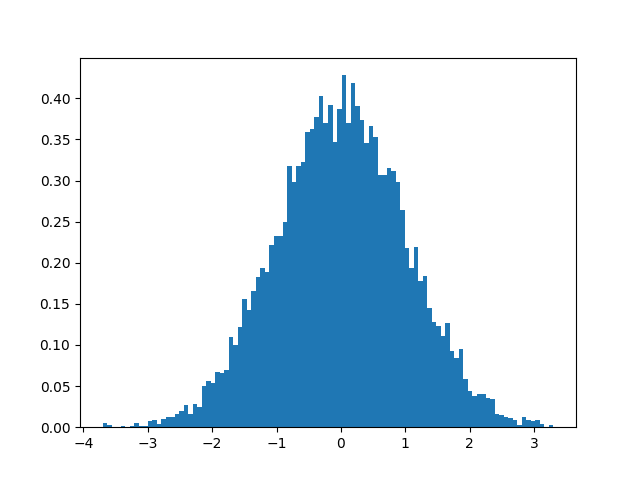

In [8]:
def plot_student_t(df: float = 1000) -> None:
    """Plot a student T histogram.

    Args:

        df: positive number is a parameter of the student t distribution (0, \\infty)
    """
    plt.figure()
    plt.hist(stats.t.rvs(df, size=10000), bins=100, density=True)
    plt.show()
plot_student_t()

We now set up the self normalized importance sampling scheme

In [9]:
@dataclass
class ImportanceSamplingEstimate:
    mc: MonteCarloEstimate
    weights: np.ndarray

def self_normalized_importance_sampling(num_samples: int,
                                        proposal_sample_generator: Callable[[int], np.ndarray],
                                        proposal_pdf_evaluator: Callable[[np.ndarray], np.ndarray],
                                        base_pdf_evaluator: Callable[[np.ndarray], np.ndarray],
                                        g_evaluator: Callable[[np.ndarray], np.ndarray]) -> ImportanceSamplingEstimate:
    """Perform self normalized importance sampling.

    Note that the code is basically the same as Monte Carlo, but with a set of weights.

    Args:

        num_samples: number of samples
        proposal_sample_generator: A function that generates samples with signature sample_generator(nsamples)
        proposal_pdf_evaluator: evaluate the pdf of the proposal *up to an normalizing constant*
        base_pdf_evaluator: evaluate the pdf of the underlying random variable *up to a normalizing constant*
        g_evaluator: a function that takes as inputs the samples and outputs the evaluations.
                     The outputs can be any dimension, however the first dimension should have size *num_samples*

    Returns:

        A self-normalized importance sampling estimator.
    """
    samples = proposal_sample_generator(num_samples)
    weights = base_pdf_evaluator(samples) / proposal_pdf_evaluator(samples)
    normalized_weights = weights / np.sum(weights)
    evaluations = g_evaluator(samples)
    estimate = np.dot(evaluations.T, normalized_weights)

    ret = ImportanceSamplingEstimate(MonteCarloEstimate(estimate, samples, evaluations), normalized_weights)
    return ret

We now use self normalized importance sampling to solve the problem

In [10]:
xpred = 0.5
def g(param: np.ndarray) -> np.ndarray:
    return param * xpred

def prop_sampler(num_samples: int, df: float = 1000.0) -> np.ndarray:
    return stats.t.rvs(df, size=num_samples)

def prop_pdf(param_samples: np.ndarray, df: float = 1000.0) -> np.ndarray:
    return stats.t.pdf(param_samples, df)

def base_pdf_unnormalized(param_samples: np.ndarray):
    return np.array([model.unnormalized_posterior(dataset.x, dataset.y, p) for p in param_samples])

Now we generate the samples and see what the prediction is: Recall that the truth is

In [11]:
true_model.slope * xpred + true_model.offset

0.1

In [12]:
Pz_is = self_normalized_importance_sampling(1000, prop_sampler, prop_pdf, base_pdf_unnormalized, g)
print("Expectation of Prediction: ", Pz_is.mc.estimate)

Expectation of Prediction:  0.10929868434710699


Pretty close, but lets see what is happening. The really nice thing about importance sampling is that you can reuse the samples for all sorts of different $g(X)$ functions! In this case all the different functions will come from choosing to predict at different locations $x \in [-1,1]$

In [13]:
@dataclass
class Prediction:
    x: np.ndarray
    mean: np.ndarray
    std_dev: np.ndarray

def predict_mean_variance_for_all_x(num_samples):
    """Predict the mean and variance of the function at all locations x

    We reuse the samples and weights to first compute two functions
    posterior mean = E[slope|data]
    posterior variance = Var(slope|data)

    Then we use the analytical expressions for the mean and variance that
    were derived above. It relies on the fact that the x\theta is linear in \theta
    """

    def g_sample(samples: np.ndarray) -> np.ndarray:
        """Function to get the expectation of the posterior parameter"""
        return samples

    Pz_param = self_normalized_importance_sampling(num_samples, prop_sampler, prop_pdf,
                                                   base_pdf_unnormalized, g_sample)

    # posterior mean and variance of the parameters
    posterior_mean = Pz_param.mc.estimate
    posterior_variance = np.dot((Pz_param.mc.evaluations - posterior_mean)**2, Pz_param.weights)
    x = np.linspace(-1, 1, 100)

    # posterior mean and variance of g(x) at all locations x
    # for general function the predicted mean would be M = np.dot(g(samples), weights)
    # for general function the predicted variance would be np.dot((g(samples) - M)**2, weights)
    pred_mean = posterior_mean * x
    pred_var = posterior_variance * x**2
    return Prediction(x, pred_mean, np.sqrt(pred_var))

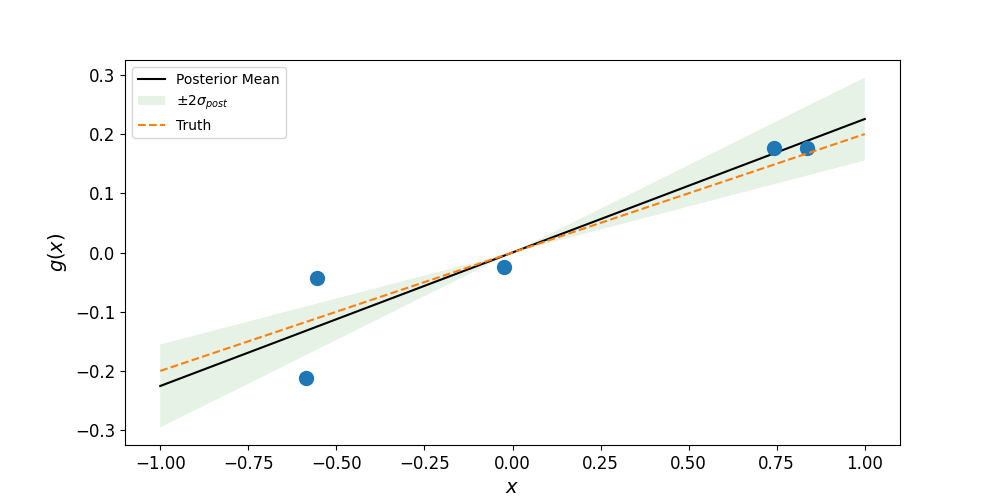

In [14]:
prediction = predict_mean_variance_for_all_x(1000)

# Plot the posterior mean += 2 standard deviation for the function
plt.figure(figsize=(10, 5))
plt.plot(prediction.x, prediction.mean, '-', color='black', label='Posterior Mean')
y1 = (prediction.mean - 2 * prediction.std_dev)
y2 = (prediction.mean + 2 * prediction.std_dev)
plt.fill_between(prediction.x, y1, y2,
                 facecolor='green', interpolate=True, alpha=0.1,
                 label=r'$\pm 2 \sigma_{post}$')
plt.plot(dataset.x, dataset.y, 'o', ms=10)
plt.plot(prediction.x, true_model.offset + true_model.slope * prediction.x, '--', label='Truth')
plt.legend()
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$g(x)$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Pretty good fit, and it recognizes that there is uncertainty in the predictions. 

Lets take a look at the Effective Sample Size

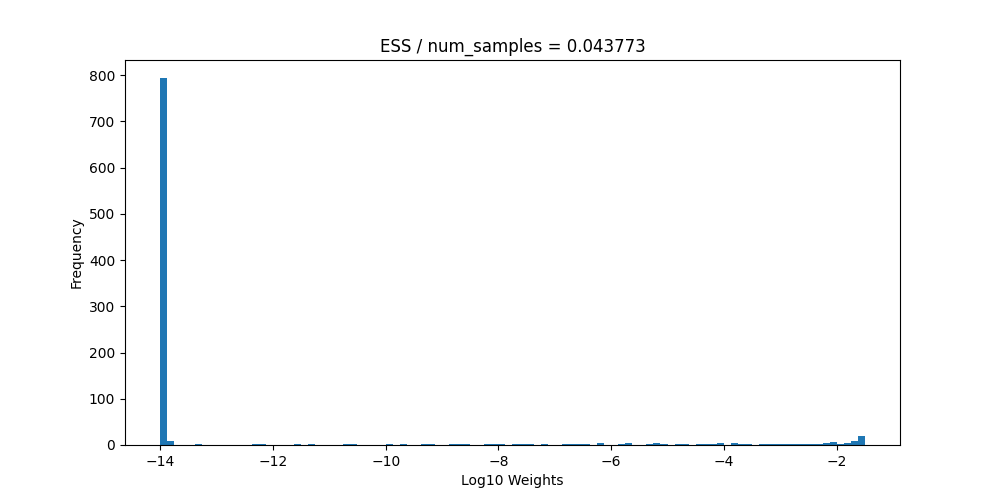

In [15]:
# Plot a Histogram of the effective sample size
plt.figure(figsize=(10, 5))
ESS = 1.0 / np.sum(Pz_is.weights**2)
plt.hist(np.log10(Pz_is.weights+1e-14), bins=100)  # added 1e-14 to avoid 0
plt.title("ESS / num_samples = {:5f}".format(ESS / Pz_is.weights.shape[0]))
plt.xlabel('Log10 Weights', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

A large amount of samples have essentially zero weight! This is indicative of a poor proposal. We see that essentially only one out of every 1 / 20 samples "counts." The problem with this proposal is it is not focused into the actual region of high posterior probability. Later in class we will see how Markov Chain Monte Carlo (MCMC) methods attempt to rectify this situation.

For now, lets try to take a look at the posterior, represented as an "empirical" distribution

In [16]:
class EmpiricalRV:
    """Represent and work with an empirical distribution."""
    weights: np.ndarray
    locations: np.ndarray

    def __init__(self, weights: np.ndarray, locations: np.ndarray) -> None:
        self.weights = weights
        self.locations = locations

    def plot(self):
        fig = plt.figure()
        plt.bar(self.locations, self.weights, width=1e-4)
        return fig

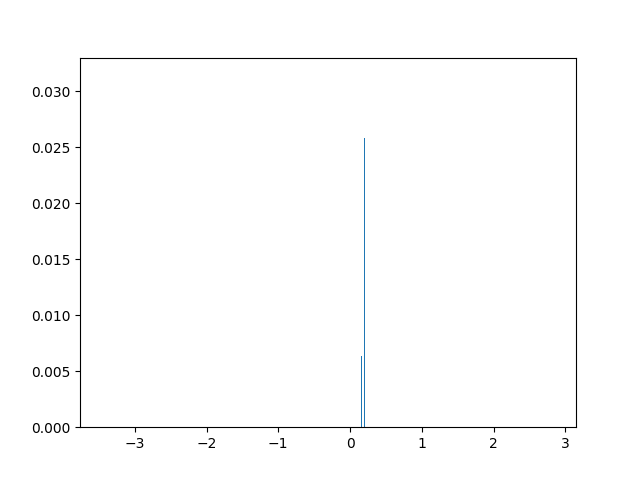

In [17]:
rv = EmpiricalRV(Pz_is.weights, Pz_is.mc.samples)
rv.plot()
plt.show()